In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [12]:
# Hyperparameters
IN_CHANNEL = 3
NUM_CLASSES = 5
# LEARNING_RATE= 1e-3
BATCH_SIZE = 10
# NUM_EPOCHS = 1

In [13]:
class Aptos(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)  # some thousand images

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0] + '.png')
        image = io.imread(img_path)
        image = Image.fromarray(image)  # Convert NumPy array to PIL Image
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)



In [14]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

# Load data
dataset = Aptos(
    csv_file='/content/drive/My Drive/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection/train.csv',
    root_dir='/content/drive/My Drive/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection/train_images',
    transform=transform
)

# Split the dataset into training and testing sets

train_set, test_set  = torch.utils.data.random_split(dataset, [2929, 733]) # this splits the training data set -> need to fix
print(len(train_set))
train_set= dataset
print(len(train_set))
# find a way to not split dataset and instead route to the test images path
# Create DataLoaders for training and testing sets

train_loader = DataLoader(dataset = train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

# Check if the DataLoader works correctly by getting a batch of data
a = next(iter(train_loader))
print(a[0].size(), a[1].size())

# print all names of images in each batch -> to see if this actually works
# create a for loop to go through each image in the batch and print them using matplotlib -> to see if this actually works, can you print the all the images

2929
3662
torch.Size([10, 3, 224, 224]) torch.Size([10])


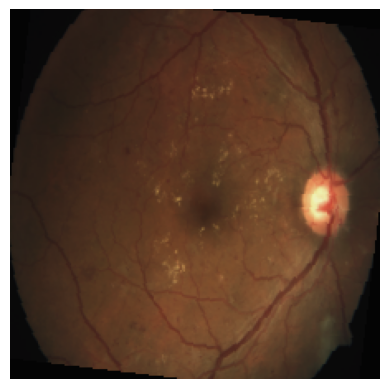

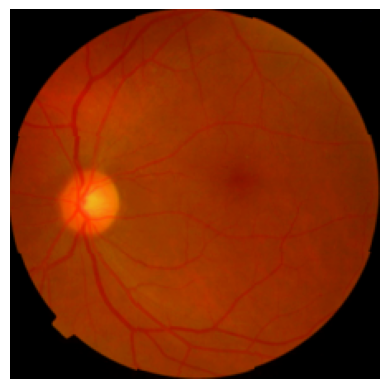

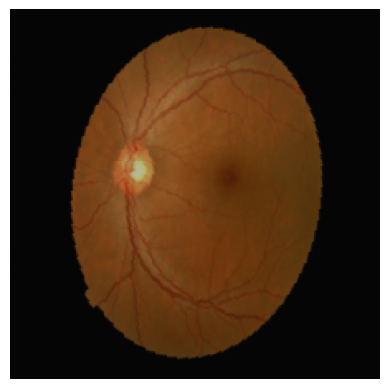

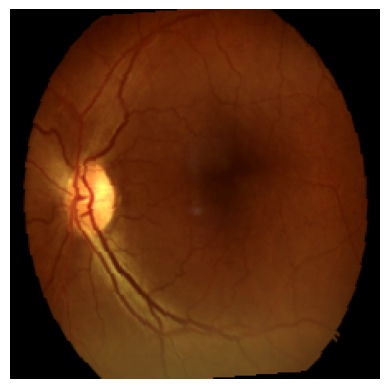

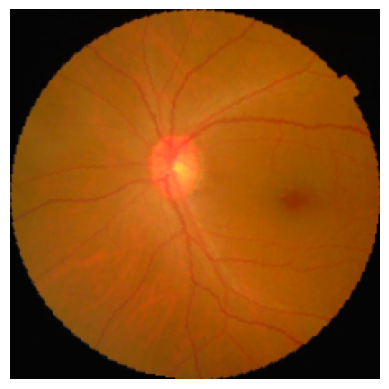

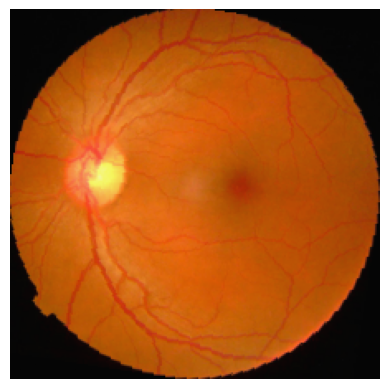

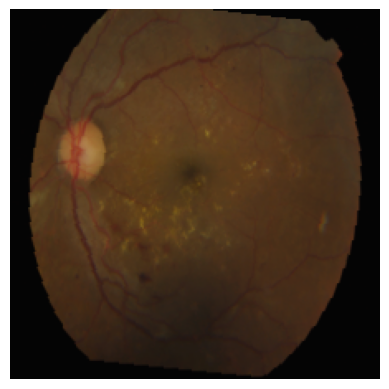

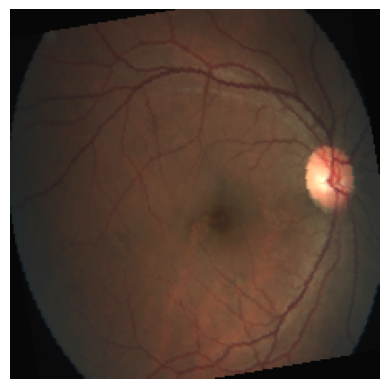

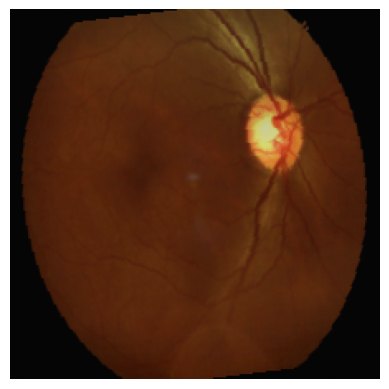

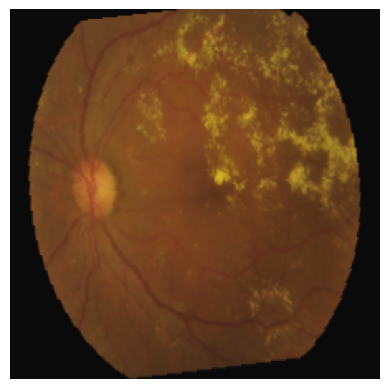

In [15]:
for i in range(BATCH_SIZE):
  plt.figure()
  plt.imshow(a[0][i].permute(1,2,0))
  plt.axis('off')
  plt.imshow

In [16]:

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        #self.conv3 = nn.Conv2d(16, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        #self.fc3 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 5)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        #self.batch_norm3 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        #x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        print(x.shape)
        x = x.view(x.shape[0], 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc3(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)  # Adjust based on your input size
        self.fc2 = nn.Linear(128, 5)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        print(f"Shape after conv1 and pool: {x.shape}")
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        print(f"Shape after conv2 and pool: {x.shape}")
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        print(f"Shape after conv3 and pool: {x.shape}")
        x = x.view(x.shape[0], -1)
        print(f"Shape after view: {x.shape}")
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train(model, train_loader, test_loader, criterion, optimizer, epochs=2):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        test_loss, test_accuracy = validate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}%, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

    return train_losses, test_losses, train_accuracies, test_accuracies

def validate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

# Assume you have train_loader and test_loader already defined
train_losses, test_losses, train_accuracies, test_accuracies = train(model, train_loader, test_loader, criterion, optimizer, epochs=5)


Shape after conv1 and pool: torch.Size([10, 16, 112, 112])
Shape after conv2 and pool: torch.Size([10, 32, 56, 56])
Shape after conv3 and pool: torch.Size([10, 64, 28, 28])
Shape after view: torch.Size([10, 50176])
Shape after conv1 and pool: torch.Size([10, 16, 112, 112])
Shape after conv2 and pool: torch.Size([10, 32, 56, 56])
Shape after conv3 and pool: torch.Size([10, 64, 28, 28])
Shape after view: torch.Size([10, 50176])
Shape after conv1 and pool: torch.Size([10, 16, 112, 112])
Shape after conv2 and pool: torch.Size([10, 32, 56, 56])
Shape after conv3 and pool: torch.Size([10, 64, 28, 28])
Shape after view: torch.Size([10, 50176])
Shape after conv1 and pool: torch.Size([10, 16, 112, 112])
Shape after conv2 and pool: torch.Size([10, 32, 56, 56])
Shape after conv3 and pool: torch.Size([10, 64, 28, 28])
Shape after view: torch.Size([10, 50176])
Shape after conv1 and pool: torch.Size([10, 16, 112, 112])
Shape after conv2 and pool: torch.Size([10, 32, 56, 56])
Shape after conv3 and po

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()